# RNA-Seq Count Normalization

**Created**: 18 December 2021

## Environment

In [1]:
if (!requireNamespace("BiocManager", quietly=TRUE)) {
    install.packages("BiocManager")
}

if (!require("limma", quietly=TRUE)) {
    BiocManager::install("limma")
}

if (!require("edgeR", quietly=TRUE)) {
    BiocManager::install("edgeR")
}

if (!require("Rtsne", quietly=TRUE)) {
    install.packages("Rtsne")
}

if (!require("UpSetR", quietly=TRUE)) {
    install.packages("UpSetR")
}

In [2]:
library(tidyverse)
library(data.table)
library(rtracklayer)
library(limma)
library(edgeR)
library(Rtsne)
library(parallel)
library(UpSetR)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attach

## Load Data

In [3]:
genes <- rtracklayer::import("/lustre/scratch118/humgen/resources/rna_seq_genomes/Homo_sapiens.GRCh38.99.gtf") %>%
    as.data.frame() %>%
    dplyr::filter(type == "gene")

In [4]:
biotypes <- c(
    "protein_coding",
    "IG_C_gene", "IG_D_gene", "IG_J_gene", "IG_V_gene",
    "TR_C_gene", "TR_D_gene", "TR_J_gene", "TR_V_gene"
)
    
genes <- genes %>%
    dplyr::filter(gene_biotype %in% biotypes)

In [5]:
read.counts <- fread("~/gains_team282/epigenetics/accessibility/analysis/rna_seq/gene_counts.tsv") %>%
    dplyr::filter(Gene %in% genes$gene_id)

In [6]:
head(read.counts)

Gene,Calderon-1001-Bulk_B-Control,Calderon-1001-Bulk_B-Treatment_1,Calderon-1001-CD8pos_T-Control,Calderon-1001-CD8pos_T-Treatment_1,Calderon-1001-Central_memory_CD8pos_T-Control,Calderon-1001-Central_memory_CD8pos_T-Treatment_1,Calderon-1001-Effector_CD4pos_T-Control,Calderon-1001-Effector_CD4pos_T-Treatment_1,Calderon-1001-Effector_memory_CD8pos_T-Control,⋯,Calderon-1010-Th17_precursors-Control,Calderon-1010-Th1_precursors-Control,Calderon-1010-Th2_precursors-Control,Calderon-1011-Monocytes-Treatment_2,Calderon-1011-Naive_B-Treatment_2,Calderon-1011-Naive_Teffs-Treatment_2,Corces-5852-Monocytes-Control,Corces-6792-Monocytes-Control,Corces-7256-Monocytes-Control,Corces-7653-Monocytes-Control
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000186092,0,0,0,7,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000284733,0,0,0,0,0,0,1,0,0,⋯,1,0,0,0,0,0,0,0,0,0
ENSG00000284662,0,0,1,0,0,0,0,0,2,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000187634,0,0,6,0,0,0,0,1,0,⋯,0,0,0,0,2,0,0,0,0,0
ENSG00000188976,2068,1970,545,11163,2208,12,911,4923,1238,⋯,387,15,9,53,107,133,71,52,21,91
ENSG00000187961,0,0,4,128,3,0,0,35,41,⋯,0,1,0,0,0,5,6,3,0,3


In [7]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_rna_seq.txt")

In [8]:
head(sample.info)

,Run,Group.ID,Sample.ID,Donor,Lineage,Cell_type,Stimulated,Treatment,Replicate,Assay.Type,⋯,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample.Name,source_name,SRA.Study
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR2753094,Corces-5852-Monocytes-Control,Corces-5852-Monocytes-Control-1,Corces-5852,MYELOID,Monocytes,FALSE,Control,1,RNA-Seq,⋯,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1915599,Mono,SRP065216
2,SRR2753100,Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control-1,Corces-6792,MYELOID,Monocytes,FALSE,Control,1,RNA-Seq,⋯,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1915605,Mono,SRP065216
3,SRR2753109,Corces-7256-Monocytes-Control,Corces-7256-Monocytes-Control-1,Corces-7256,MYELOID,Monocytes,FALSE,Control,1,RNA-Seq,⋯,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1915614,Mono,SRP065216
4,SRR2753119,Corces-7653-Monocytes-Control,Corces-7653-Monocytes-Control-1,Corces-7653,MYELOID,Monocytes,FALSE,Control,1,RNA-Seq,⋯,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1915624,Mono,SRP065216
5,SRR11007061,Calderon-1001-CD8pos_T-Control,Calderon-1001-CD8pos_T-Control-1,Calderon-1001,CD8,CD8pos_T,FALSE,Control,1,RNA-Seq,⋯,Illumina NovaSeq 6000,PAIRED,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319750,primary blood,SRP156452
6,SRR11007062,Calderon-1001-CD8pos_T-Treatment_1,Calderon-1001-CD8pos_T-Treatment_1-1,Calderon-1001,CD8,CD8pos_T,TRUE,Treatment_1,1,RNA-Seq,⋯,Illumina NovaSeq 6000,PAIRED,cDNA,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319751,primary blood,SRP156452


In [9]:
qc <- read.table("~/gains_team282/epigenetics/accessibility/analysis/rna_seq/rnaseqc.tsv", sep="\t", quote=c(), header=T, row.names=1, check.names=F)

qc <- as.data.frame(t(qc)) %>%
    dplyr::mutate(Group.ID=rownames(.)) %>%
    dplyr::select(Group.ID, everything())

colnames(qc) <- make.names(colnames(qc))

qc <- qc %>%
    dplyr::mutate(Proportion.Low.Mapping.Quality=Low.Mapping.Quality / Mapped.Reads)

In [10]:
head(qc)

,Group.ID,Mapping.Rate,Unique.Rate.of.Mapped,Duplicate.Rate.of.Mapped,Duplicate.Rate.of.Mapped..excluding.Globins,Base.Mismatch,End.1.Mapping.Rate,End.2.Mapping.Rate,End.1.Mismatch.Rate,End.2.Mismatch.Rate,⋯,X3..bias.Std,X3..bias.MAD_Std,X3..Bias..25th.Percentile,X3..Bias..75th.Percentile,Median.of.Avg.Transcript.Coverage,Median.of.Transcript.Coverage.Std,Median.of.Transcript.Coverage.CV,Median.Exon.CV,Exon.CV.MAD,Proportion.Low.Mapping.Quality
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Calderon-1003-Regulatory_T-Control,Calderon-1003-Regulatory_T-Control,1,0.417506,0.582494,0.582494,0,0,0,NaN,NaN,⋯,0.366025,0.581744,0.1810340,0.957447,0.0000000,0.000000,3.27850,0.847009,1.062230,0.06046678
Calderon-1004-CD8pos_T-Treatment_1,Calderon-1004-CD8pos_T-Treatment_1,1,0.513875,0.486125,0.486127,0,0,0,NaN,NaN,⋯,0.323368,0.434766,0.1851850,0.772414,0.0000000,0.000000,1.80903,0.292417,0.336902,0.05106423
Calderon-1009-Mature_NK-Treatment_2,Calderon-1009-Mature_NK-Treatment_2,1,0.550788,0.449212,0.449212,0,0,0,NaN,NaN,⋯,0.326591,0.373401,0.0909091,0.648148,0.0000000,0.000000,2.93805,0.544710,0.601185,0.05253940
Calderon-1010-Monocytes-Treatment_2,Calderon-1010-Monocytes-Treatment_2,1,0.664773,0.335227,0.335227,0,0,0,NaN,NaN,⋯,0.370326,0.611256,0.2074200,0.967480,0.0458996,0.257737,3.96029,1.603610,1.256850,0.07577716
Calderon-1001-Naive_CD8_T-Control,Calderon-1001-Naive_CD8_T-Control,1,0.556475,0.443525,0.443526,0,0,0,NaN,NaN,⋯,0.309379,0.375817,0.1038960,0.636364,0.0000000,0.000000,1.68668,0.293975,0.299127,0.07052313
Calderon-1001-Memory_Teffs-Control,Calderon-1001-Memory_Teffs-Control,1,0.563167,0.436833,0.436834,0,0,0,NaN,NaN,⋯,0.308688,0.373347,0.0960452,0.621469,0.0000000,0.000000,1.50305,0.282169,0.284696,0.09668839


## Limma-Voom Modeling

### Count Matrix

Set up the count matrix in the format required for Limma.

In [11]:
count.mtx <- as.matrix(read.counts[,-1])
rownames(count.mtx) <- read.counts$Gene

In [12]:
head(count.mtx)

,Calderon-1001-Bulk_B-Control,Calderon-1001-Bulk_B-Treatment_1,Calderon-1001-CD8pos_T-Control,Calderon-1001-CD8pos_T-Treatment_1,Calderon-1001-Central_memory_CD8pos_T-Control,Calderon-1001-Central_memory_CD8pos_T-Treatment_1,Calderon-1001-Effector_CD4pos_T-Control,Calderon-1001-Effector_CD4pos_T-Treatment_1,Calderon-1001-Effector_memory_CD8pos_T-Control,Calderon-1001-Effector_memory_CD8pos_T-Treatment_1,⋯,Calderon-1010-Th17_precursors-Control,Calderon-1010-Th1_precursors-Control,Calderon-1010-Th2_precursors-Control,Calderon-1011-Monocytes-Treatment_2,Calderon-1011-Naive_B-Treatment_2,Calderon-1011-Naive_Teffs-Treatment_2,Corces-5852-Monocytes-Control,Corces-6792-Monocytes-Control,Corces-7256-Monocytes-Control,Corces-7653-Monocytes-Control
ENSG00000186092,0,0,0,7,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000284733,0,0,0,0,0,0,1,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
ENSG00000284662,0,0,1,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000187634,0,0,6,0,0,0,0,1,0,0,⋯,0,0,0,0,2,0,0,0,0,0
ENSG00000188976,2068,1970,545,11163,2208,12,911,4923,1238,1208,⋯,387,15,9,53,107,133,71,52,21,91
ENSG00000187961,0,0,4,128,3,0,0,35,41,1,⋯,0,1,0,0,0,5,6,3,0,3


In [13]:
filtered.samples <- qc$Group.ID[qc$Mapped.Reads > 1e7]
count.mtx <- count.mtx[, filtered.samples]

In [14]:
setdiff(sample.info$Group.ID, filtered.samples)

[1] "Calderon-1003-Effector_CD4pos_T-Control"

In [15]:
dim(count.mtx)

[1] 20376   169

### Create Sample Groups

The samples are grouped using cell type and treatment condition. The cell type and treatment group for each sample is stored in `groups`.

In [16]:
cell.type <- sample.info[match(colnames(count.mtx), sample.info$Group.ID), "Cell_type"]
stimulated <- ifelse(sample.info[match(colnames(count.mtx), sample.info$Group.ID), "Stimulated"] == FALSE, "Baseline", "Stimulated")
groups <- interaction(cell.type, stimulated, sep="_")
groups <- droplevels(groups)

I will also be normalizing the data by removing batch effects. The donor is used as a categorical batch.

In [17]:
donors <- factor(sample.info[match(colnames(count.mtx), sample.info$Group.ID), "Donor"])
donors <- droplevels(donors)

I will also include the proportion of poor quality reads from RNA-SeQC.

In [18]:
low.quality <- qc[match(colnames(count.mtx), qc$Group.ID), "Proportion.Low.Mapping.Quality"]

The design matrix indicates which samples belong to which groups.

In [19]:
design <- model.matrix(~0 + groups + donors + low.quality)

### Create DGEList

`edgeR` can be used to handle count matrices. We will use `voom` in the next step to process this `edgeR` object.

In [20]:
dge <- DGEList(count.mtx)

Filter genes using in-built `edgeR` function.

In [21]:
keep <- filterByExpr(dge, group=groups, min.count=50, min.total.count=200, min.prop=1)
dge <- dge[keep, , keep.lib.sizes=FALSE]

In [22]:
dim(dge)

[1] 17258   169

Calculate normalization factors for the trimmed mean of M-values method.

In [23]:
dge <- calcNormFactors(dge, method="TMM")

### Voom

`voom` models a count matrix by empirically identifying the mean-variance relationship within the data. The count matrix can then be normalized and batch effects can be removed. The normalized data can be used in downstream analysis with `limma`.

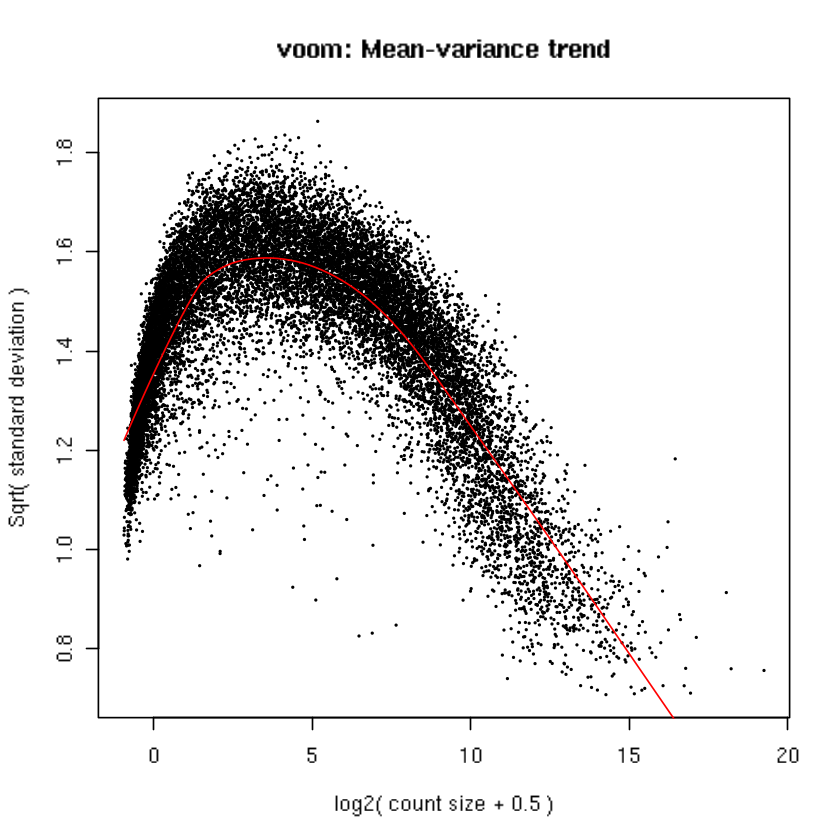

In [24]:
y <- voom(dge, design, plot=TRUE)

### Visualize Normalized Counts

In [25]:
y.r <- removeBatchEffect(y, batch=groups, batch2=donors)

In [26]:
pca <- prcomp(t(as.matrix(y.r)))

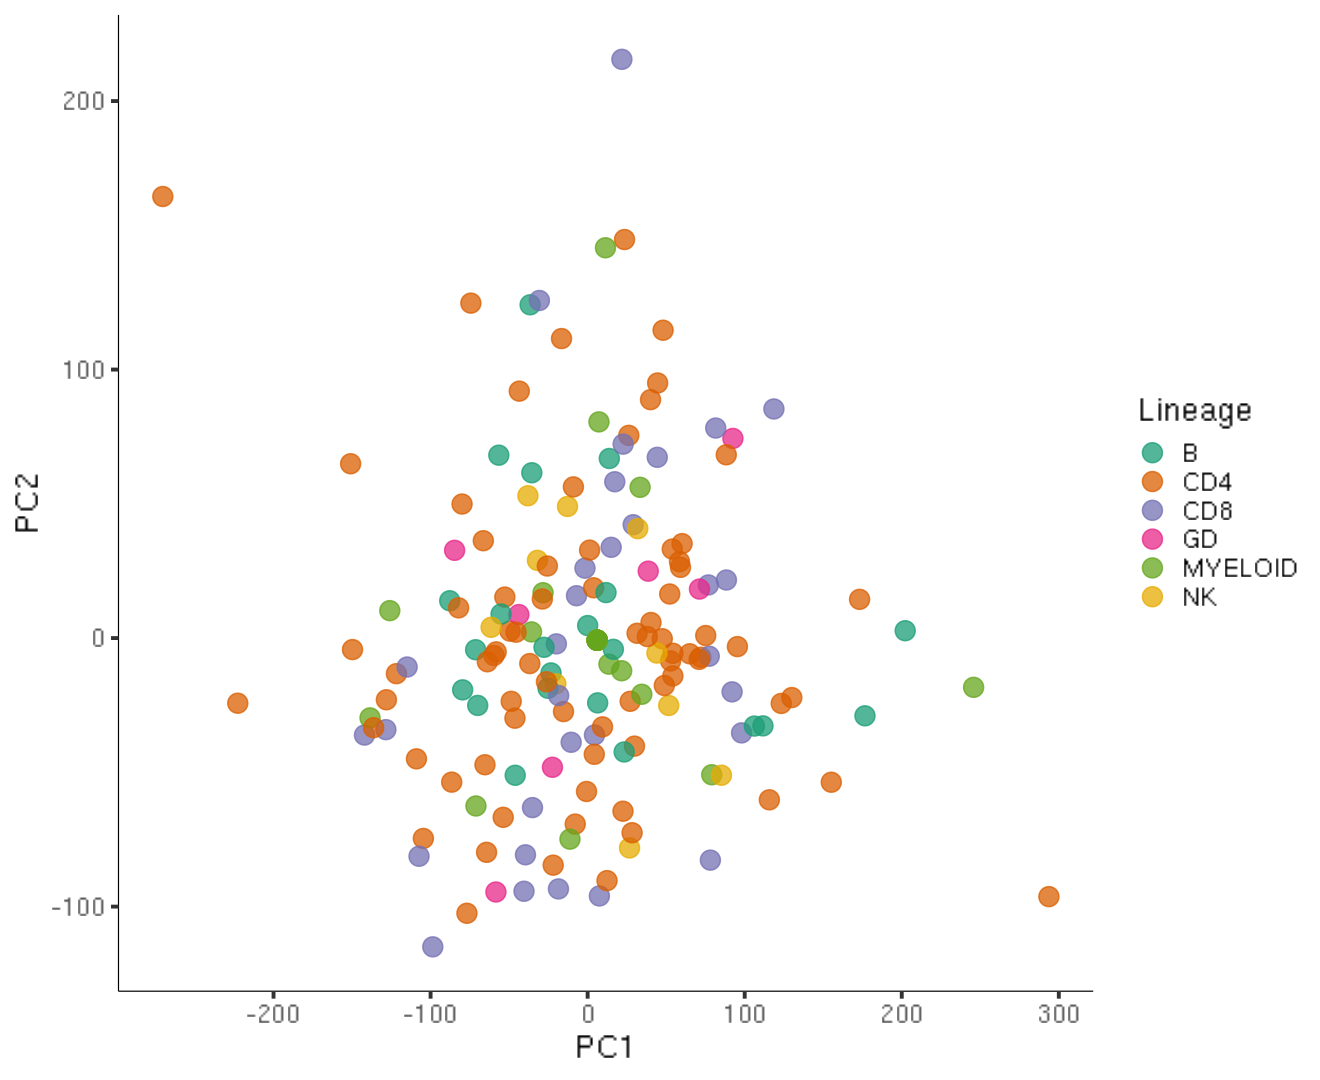

In [27]:
options(repr.plot.width=11, repr.plot.height=9)

merge(pca$x, sample.info, by.x=0, by.y="Group.ID") %>%
    as.data.frame() %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2, color=Lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    labs(color="Lineage") +
    ggplot_theme +
    theme(legend.position="right")

ggsave("03_Functional_Interpretation/results/normalized_read_count_pca.svg", width=8, height=9)

In [28]:
set.seed(9873945)
tsne.res <- Rtsne(t(as.matrix(y.r)[,stimulated == "Baseline"]), num_threads=4, perplexity=15)

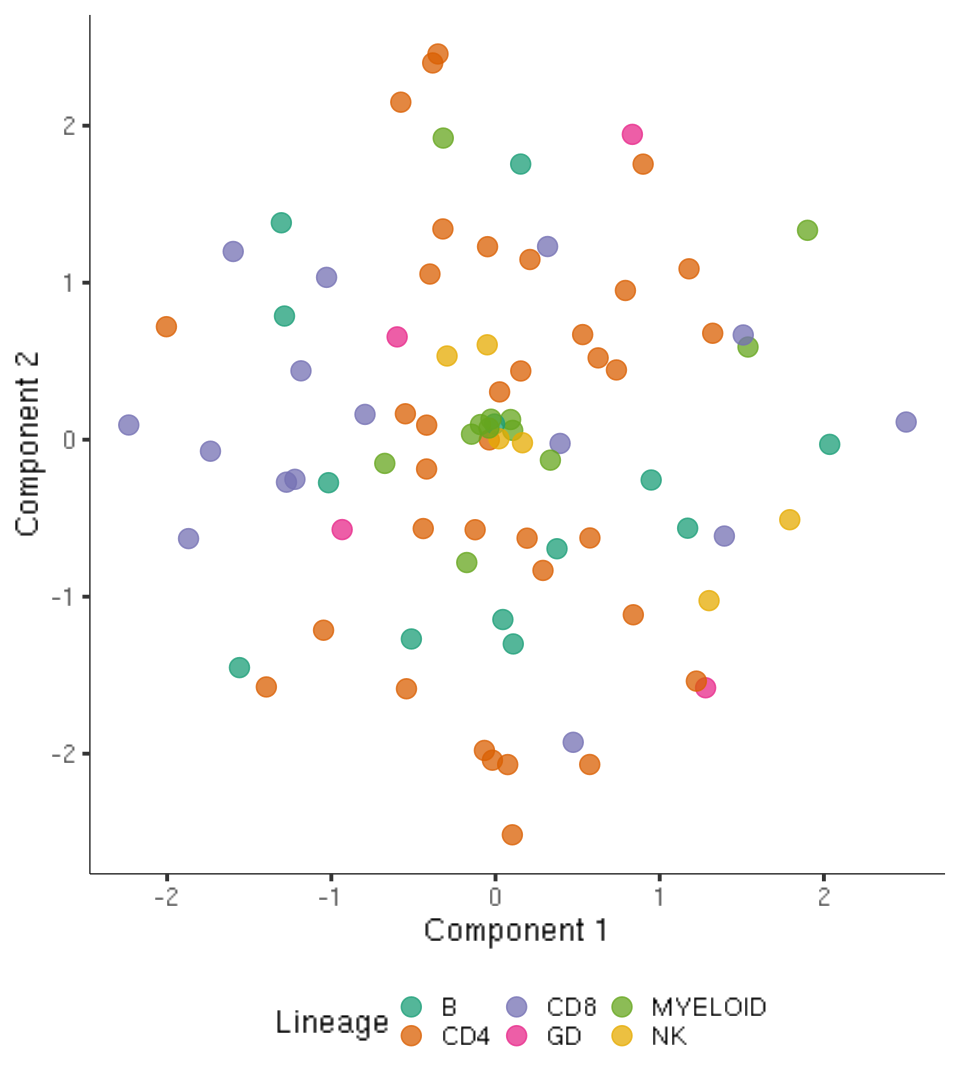

In [29]:
options(repr.plot.width=8, repr.plot.height=9)

tsne.res$Y %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Group.ID=colnames(as.matrix(y)[,stimulated == "Baseline"])) %>%
    merge(., sample.info, by="Group.ID") %>%
    ggplot() +
    geom_point(aes(x=Comp1, y=Comp2, color=Lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/normalized_read_count_tsne.svg", width=8, height=9)

### Limma

Use `limma` to fit a linear model consisting of the biological `groups`.

In [30]:
fit <- lmFit(y, design)

### Limma DE Genes

Identify all cell types where both the baseline and stimulated conditions are present.

In [31]:
cell.type.conditions <- cbind(cell.type, stimulated) %>%
    as.data.frame() %>%
    dplyr::select(Cell.Type=1, Stimulated=2) %>%
    dplyr::group_by(Cell.Type, Stimulated) %>%
    dplyr::summarize(N=n(), .groups="drop") %>%
    tidyr::spread(Stimulated, N) %>%
    na.omit()

Create contrasts for each cell type that has both baseline and stimulated conditions.

In [32]:
contrast <- matrix(0, nrow=ncol(coef(fit)), ncol=nrow(cell.type.conditions))
rownames(contrast) <- colnames(coef(fit))
colnames(contrast) <- paste0(cell.type.conditions$Cell.Type, "_Stimulated-", cell.type.conditions$Cell.Type, "_Baseline")

for (i in 1:nrow(cell.type.conditions)) {
    cell.type.condition = cell.type.conditions$Cell.Type[i]
    contrast[paste0("groups", cell.type.condition, "_Stimulated"), i] = 1
    contrast[paste0("groups", cell.type.condition, "_Baseline"), i] = -1
}

In [33]:
de.genes <- rbindlist(lapply(1:ncol(contrast), function(i) {
    de.res = eBayes(contrasts.fit(fit, contrast[,i]))
    de.res.table = topTable(de.res, sort.by="p", n=Inf)
    
    contrast.cell.type = strsplit(colnames(contrast)[i], "-")[[1]][1]
    contrast.cell.type = substr(contrast.cell.type, start=1, stop=nchar(contrast.cell.type) - 11)

    de.res.table %>%
        dplyr::mutate(Contrast=colnames(contrast)[i]) %>%
        dplyr::mutate(Cell.Type=contrast.cell.type) %>%
        dplyr::mutate(Gene.ID=rownames(.)) %>%
        dplyr::select(Contrast, Cell.Type, Gene.ID, logFC, AveExpr, t, P.Value, adj.P.Val, B)
}))

## Differentially Expressed Genes

Calculate differentially expressed genes. For each contrast, a peak is considered differentially accessible if the adjusted P-value is < 0.01 and the absolute log fold change is greater than 1.

In [34]:
de.genes.set <- de.genes %>%
    dplyr::filter(abs(logFC) > 1) %>%
    dplyr::filter(adj.P.Val < 0.01)

write.csv(de.genes.set, "~/gains_team282/epigenetics/accessibility/analysis/rna_seq/de_genes_set.csv")

There are 31,073 unique DE genes across all contrasts.

In [35]:
length(unique(de.genes.set$Gene.ID))

[1] 3847

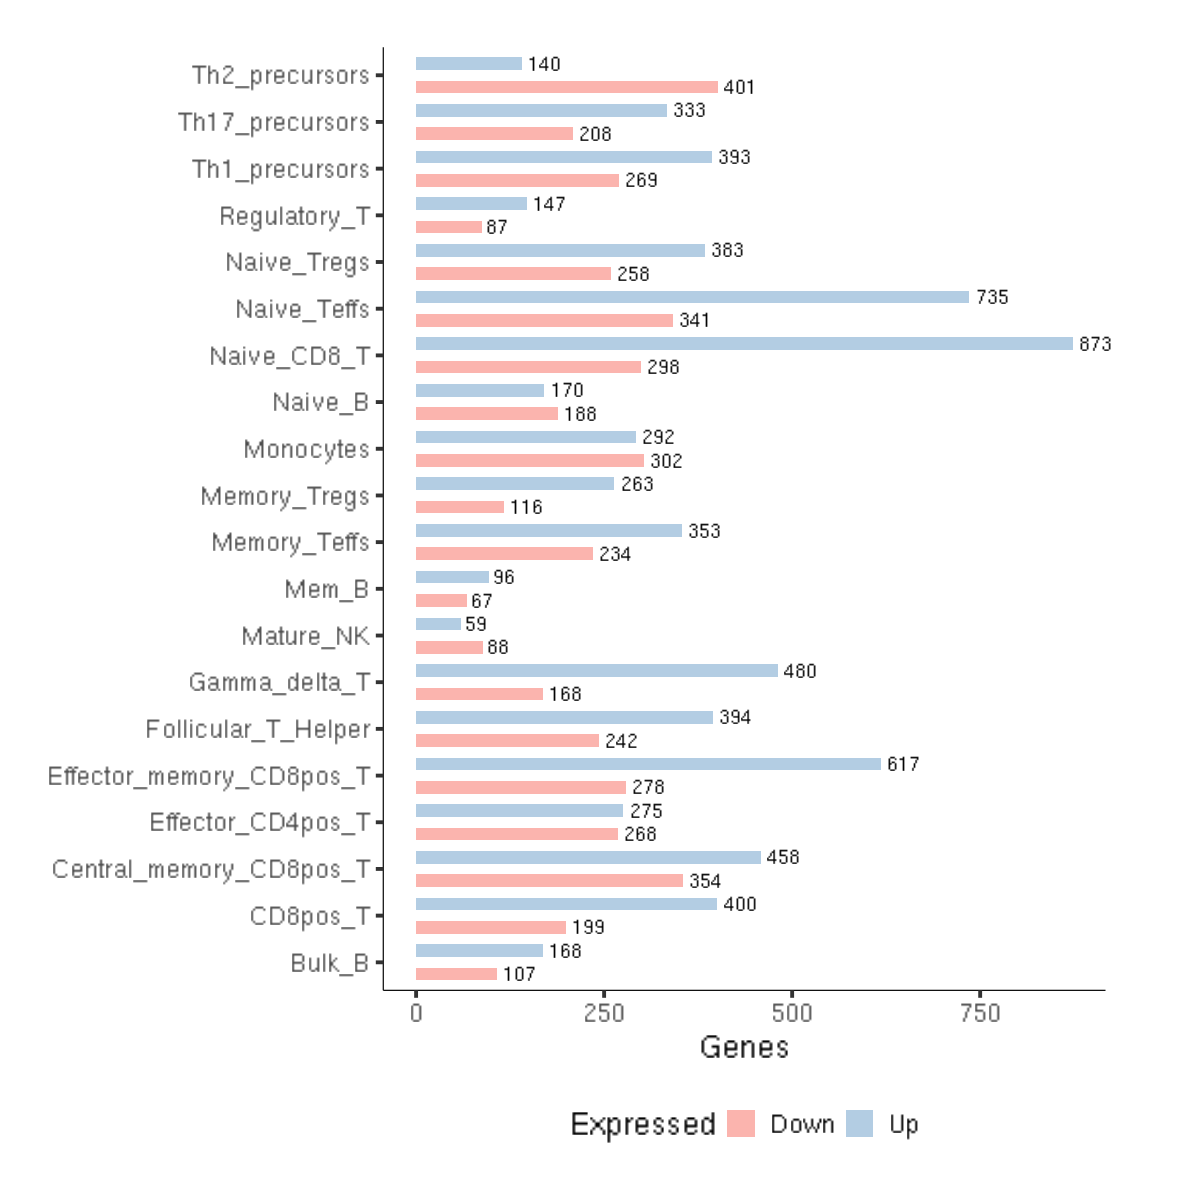

In [36]:
options(repr.plot.width=10, repr.plot.height=10)

de.genes.set %>%
    dplyr::mutate(Expressed=ifelse(logFC > 1, "Up", "Down")) %>%
    dplyr::group_by(Cell.Type, Expressed) %>%
    dplyr::summarize(Genes=n(), .groups="drop") %>%
    ggplot() +
    geom_bar(aes(x=Cell.Type, y=Genes, fill=Expressed), stat="identity", width=0.5, position=position_dodge(width=1)) +
    geom_text(aes(x=Cell.Type, y=Genes, label=Genes, group=Expressed), hjust=-0.2, vjust=0.5, position=position_dodge(width=1)) +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip(clip="off") +
    ggplot_theme +
    theme(axis.title.y.left=element_blank(), plot.margin=margin(1, 2, 1, 1, "cm"))

ggsave("03_Functional_Interpretation/results/immune_de_genes_counts.pdf", width=10, height=10)

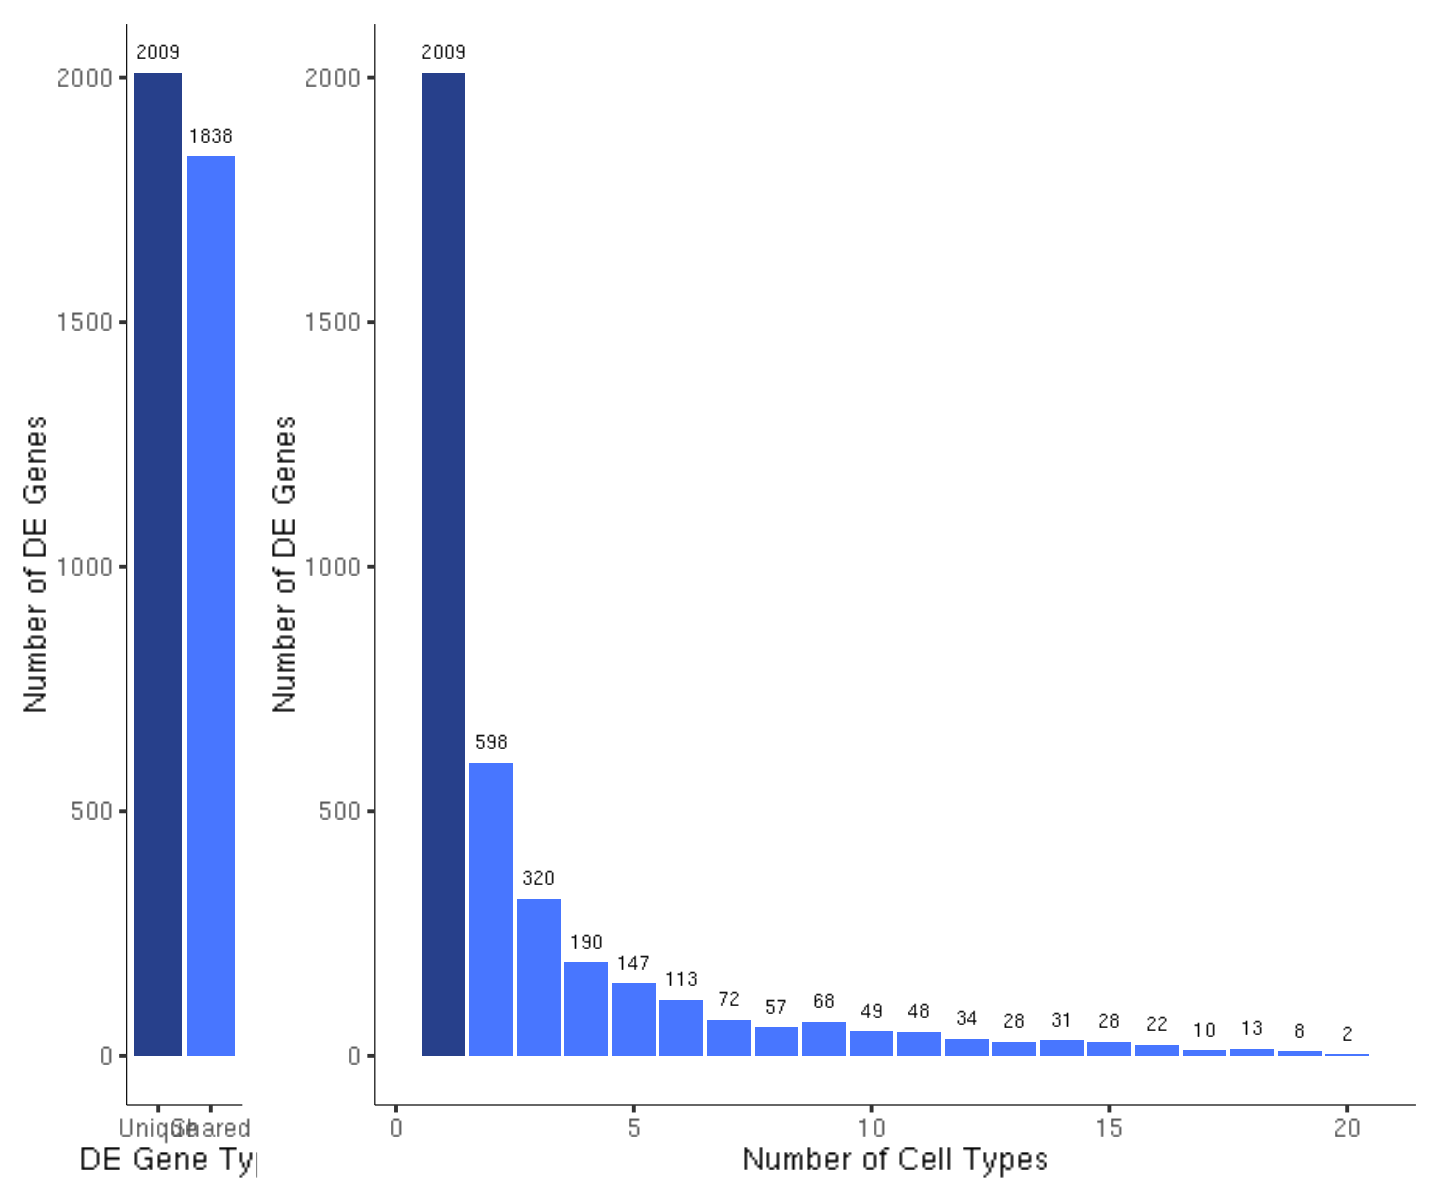

In [41]:
options(repr.plot.width=12, repr.plot.height=10)

p1 <- de.genes.set %>%
    dplyr::count(Gene.ID) %>%
    dplyr::count(n, name="Count") %>%
    dplyr::mutate(Type=factor(ifelse(n == 1, "Unique", "Shared"), levels=c("Unique", "Shared"))) %>%
    ggplot() +
    geom_bar(aes(x=n, y=Count, fill=Type), stat="identity") +
    geom_text(aes(x=n, y=Count, label=Count), vjust=-1) +
    guides(fill="none") +
    scale_fill_manual(values=c("royalblue4", "royalblue1")) +
    xlab("Number of Cell Types") + ylab("Number of DE Genes") +
    ggplot_theme

p2 <- de.genes.set %>%
    dplyr::count(Gene.ID) %>%
    dplyr::count(n, name="Count") %>%
    dplyr::mutate(Type=factor(ifelse(n == 1, "Unique", "Shared"), levels=c("Unique", "Shared"))) %>%
    dplyr::group_by(Type) %>%
    dplyr::tally(Count) %>%
    ggplot() +
    geom_bar(aes(x=Type, y=n, fill=Type), stat="identity") +
    geom_text(aes(x=Type, y=n, label=n), vjust=-1) +
    guides(fill="none") +
    scale_fill_manual(values=c("royalblue4", "royalblue1")) +
    xlab("DE Gene Type") + ylab("Number of DE Genes") +
    ggplot_theme

p2 + p1 + plot_layout(widths=c(1, 9))

ggsave("03_Functional_Interpretation/results/immune_de_genes_n_cell_types.pdf", width=12, height=10)

Consistency of direction of effect - 1838 DE genes are present in more than one cell type. 1793 DE genes are consistently upregulated or downregulated across cell types. Only 45 are upregulated and downregulated in different cell types.

In [61]:
de.genes.set %>%
    dplyr::mutate(Expressed=ifelse(logFC > 1, "Up", "Down")) %>%
    dplyr::count(Gene.ID, Expressed) %>%
    tidyr::spread(Expressed, n, fill=0) %>%
    dplyr::filter(Up + Down > 1) %>%
    dplyr::mutate(Both=(Up > 0) & (Down > 0)) %>%
    dplyr::count(Both) %>%
    dplyr::mutate(Total = sum(n)) %>%
    dplyr::mutate(Prop = n / Total)

Both,n,Total,Prop
<lgl>,<int>,<int>,<dbl>
FALSE,1793,1838,0.97551687
TRUE,45,1838,0.02448313
